# Лекция 05. Где логистическая регрессия хороша, а где нет

### Анализ отзывов о фильмах IMDB

А теперь немного потренируемся! Мы хотим решить задачу бинарной классификации обзоров фильмов IMDB. У нас есть обучающий набор с отмеченными отзывами, 12500 отзывов отмечены как хорошие, еще 12500 плохих. Здесь нелегко сразу приступить к машинному обучению, потому что у нас нет готовой матрицы $X$; нам нужно ее подготовить. Мы будем использовать простой подход: модель мешка слов  ("Bag of words"). Признаки будут представлены показателями наличия каждого слова из всего корпуса в данном обзоре на фильм. Корпус - это совокупность всех отзывов пользователей. Идея иллюстрируется картинкой

<img src="../../img/bag_of_words.svg" width=80% />

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_files
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression

**Чтобы начать работу, мы автоматически загружаем [набор данных](http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz)  и разархивируйте его вместе с остальными наборами данных в папке data. Набор данных кратко описан [здесь](http://ai.stanford.edu/~amaas/data/sentiment/). В тестовых и тренировочных наборах есть 12,5 тыс хороших и плохих отзывов.**

In [2]:
from io import BytesIO
import requests
import tarfile

url = "http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

def load_imdb_dataset(extract_path="../../data", overwrite=False):
    #check if existed already
    if os.path.isfile(os.path.join(extract_path, "aclImdb", "README")) and not overwrite:
        print("IMDB dataset is already in place.")
        return
    
    print("Downloading the dataset from:  ", url)
    response = requests.get(url)
    
    tar = tarfile.open(mode= "r:gz", fileobj = BytesIO(response.content))
    
    data = tar.extractall(extract_path)
    
load_imdb_dataset()

In [3]:
#change if you have it in alternative location
PATH_TO_IMDB = "../../data/aclImdb"

reviews_train = load_files(os.path.join(PATH_TO_IMDB, "train"),
                           categories=['pos', 'neg'])
text_train, y_train = reviews_train.data, reviews_train.target

reviews_test = load_files(os.path.join(PATH_TO_IMDB, "test"),
                          categories=['pos', 'neg'])
text_test, y_test = reviews_test.data, reviews_test.target

In [4]:
# # Alternatively, load data from previously pickled objects. 
# import pickle
# with open('../../data/imdb_text_train.pkl', 'rb') as f:
#     text_train = pickle.load(f)
# with open('../../data/imdb_text_test.pkl', 'rb') as f:
#     text_test = pickle.load(f)
# with open('../../data/imdb_target_train.pkl', 'rb') as f:
#     y_train = pickle.load(f)
# with open('../../data/imdb_target_test.pkl', 'rb') as f:
#     y_test = pickle.load(f)

In [5]:
print("Number of documents in training data: %d" % len(text_train))
print(np.bincount(y_train))
print("Number of documents in test data: %d" % len(text_test))
print(np.bincount(y_test))

Number of documents in training data: 25000
[12500 12500]
Number of documents in test data: 25000
[12500 12500]


**Вот несколько примеров отзывов**

In [6]:
print(text_train[1])

b'Words can\'t describe how bad this movie is. I can\'t explain it by writing only. You have too see it for yourself to get at grip of how horrible a movie really can be. Not that I recommend you to do that. There are so many clich\xc3\xa9s, mistakes (and all other negative things you can imagine) here that will just make you cry. To start with the technical first, there are a LOT of mistakes regarding the airplane. I won\'t list them here, but just mention the coloring of the plane. They didn\'t even manage to show an airliner in the colors of a fictional airline, but instead used a 747 painted in the original Boeing livery. Very bad. The plot is stupid and has been done many times before, only much, much better. There are so many ridiculous moments here that i lost count of it really early. Also, I was on the bad guys\' side all the time in the movie, because the good guys were so stupid. "Executive Decision" should without a doubt be you\'re choice over this one, even the "Turbulenc

In [7]:
y_train[1] # bad review

0

In [8]:
text_train[2]

b'Everyone plays their part pretty well in this "little nice movie". Belushi gets the chance to live part of his life differently, but ends up realizing that what he had was going to be just as good or maybe even better. The movie shows us that we ought to take advantage of the opportunities we have, not the ones we do not or cannot have. If U can get this movie on video for around $10, it\xc2\xb4d be an investment!'

In [9]:
y_train[2] # good review

1

In [10]:
# import pickle
# with open('../../data/imdb_text_train.pkl', 'wb') as f:
#     pickle.dump(text_train, f)
# with open('../../data/imdb_text_test.pkl', 'wb') as f:
#     pickle.dump(text_test, f)
# with open('../../data/imdb_target_train.pkl', 'wb') as f:
#     pickle.dump(y_train, f)
# with open('../../data/imdb_target_test.pkl', 'wb') as f:
#     pickle.dump(y_test, f)

## Простой подсчет слов

**Во-первых, мы создадим словарь всех слов с помощью CountVectorizer**

In [11]:
cv = CountVectorizer()
cv.fit(text_train)

len(cv.vocabulary_)

74849

**Если вы посмотрите на примеры "слов" (назовем их лексемами), то увидите, что мы опустили многие важные шаги в обработке текста (автоматическая обработка текста сама по себе может быть совершенно отдельной серией лекций).**

In [12]:
print(cv.get_feature_names()[:50])
print(cv.get_feature_names()[50000:50050])

['00', '000', '0000000000001', '00001', '00015', '000s', '001', '003830', '006', '007', '0079', '0080', '0083', '0093638', '00am', '00pm', '00s', '01', '01pm', '02', '020410', '029', '03', '04', '041', '05', '050', '06', '06th', '07', '08', '087', '089', '08th', '09', '0f', '0ne', '0r', '0s', '10', '100', '1000', '1000000', '10000000000000', '1000lb', '1000s', '1001', '100b', '100k', '100m']
['pincher', 'pinchers', 'pinches', 'pinching', 'pinchot', 'pinciotti', 'pine', 'pineal', 'pineapple', 'pineapples', 'pines', 'pinet', 'pinetrees', 'pineyro', 'pinfall', 'pinfold', 'ping', 'pingo', 'pinhead', 'pinheads', 'pinho', 'pining', 'pinjar', 'pink', 'pinkerton', 'pinkett', 'pinkie', 'pinkins', 'pinkish', 'pinko', 'pinks', 'pinku', 'pinkus', 'pinky', 'pinnacle', 'pinnacles', 'pinned', 'pinning', 'pinnings', 'pinnochio', 'pinnocioesque', 'pino', 'pinocchio', 'pinochet', 'pinochets', 'pinoy', 'pinpoint', 'pinpoints', 'pins', 'pinsent']


**Во-вторых, мы кодируем предложения из текстов обучающего набора с индексами входящих слов. Мы будем использовать разреженный формат.**

In [13]:
X_train = cv.transform(text_train)
X_train

<25000x74849 sparse matrix of type '<class 'numpy.int64'>'
	with 3445861 stored elements in Compressed Sparse Row format>

**Давайте посмотрим, как сработало наше преобразование**

In [14]:
print(text_train[19726])

b'This movie is terrible but it has some good effects.'


In [15]:
X_train[19726].nonzero()[1]

array([ 9881, 21020, 28068, 29999, 34585, 34683, 44147, 61617, 66150, 66562], dtype=int32)

In [16]:
X_train[19726].nonzero()

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32),
 array([ 9881, 21020, 28068, 29999, 34585, 34683, 44147, 61617, 66150, 66562], dtype=int32))

**В-третьих, мы применим те же операции к тестовому набору**

In [18]:
X_test = cv.transform(text_test)

**Следующий шаг - обучение логистической регрессии.**

In [19]:
%%time
logit = LogisticRegression(solver='lbfgs', n_jobs=-1, random_state=7)
logit.fit(X_train, y_train)

CPU times: user 31.2 ms, sys: 609 ms, total: 641 ms
Wall time: 8.48 s


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=-1, penalty='l2', random_state=7,
                   solver='lbfgs', tol=0.0001, verbose=0, warm_start=False)

**Давайте посмотрим на точность как на тренировочных, так и на тестовых наборах.**

In [20]:
round(logit.score(X_train, y_train), 3), round(logit.score(X_test, y_test), 3),

(0.98099999999999998, 0.86399999999999999)

**Коэффициенты модели можно красиво отобразить.**

In [21]:
def visualize_coefficients(classifier, feature_names, n_top_features=25):
    # get coefficients with large absolute values 
    coef = classifier.coef_.ravel()
    positive_coefficients = np.argsort(coef)[-n_top_features:]
    negative_coefficients = np.argsort(coef)[:n_top_features]
    interesting_coefficients = np.hstack([negative_coefficients, positive_coefficients])
    # plot them
    plt.figure(figsize=(15, 5))
    colors = ["red" if c < 0 else "blue" for c in coef[interesting_coefficients]]
    plt.bar(np.arange(2 * n_top_features), coef[interesting_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 1 + 2 * n_top_features), feature_names[interesting_coefficients], rotation=60, ha="right");


In [22]:
def plot_grid_scores(grid, param_name):
    plt.plot(grid.param_grid[param_name], grid.cv_results_['mean_train_score'],
        color='green', label='train')
    plt.plot(grid.param_grid[param_name], grid.cv_results_['mean_test_score'],
        color='red', label='test')
    plt.legend();
    

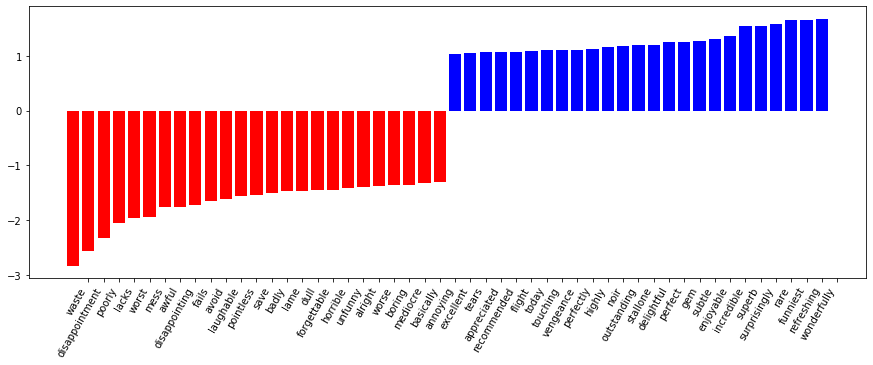

In [23]:
visualize_coefficients(logit, cv.get_feature_names())

**Чтобы сделать нашу модель лучше, мы можем оптимизировать коэффициент регуляризации для `Logistic Regression`(логистической регрессии). Мы будем использовать `sklearn.pipeline`, потому что `CountVectorizer` должен применяться только к обучающим данным (чтобы не "заглядывать" в тестовый набор и не считать частоты слов там). В этом случае `pipeline` определяет правильную последовательность действий: применить `CountVectorizer`, затем обучить `Logistic Regression`.**

In [24]:
%%time
from sklearn.pipeline import make_pipeline

text_pipe_logit = make_pipeline(CountVectorizer(),
                                # for some reason n_jobs > 1 won't work 
                                # with GridSearchCV's n_jobs > 1
                                LogisticRegression(solver='lbfgs', 
                                                   n_jobs=1,
                                                   random_state=7))

text_pipe_logit.fit(text_train, y_train)
print(text_pipe_logit.score(text_test, y_test))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


0.8642
CPU times: user 23.8 s, sys: 7.16 s, total: 30.9 s
Wall time: 21.9 s


In [25]:
%%time
from sklearn.model_selection import GridSearchCV

param_grid_logit = {'logisticregression__C': np.logspace(-5, 0, 6)}
grid_logit = GridSearchCV(text_pipe_logit, 
                          param_grid_logit, 
                          return_train_score=True, 
                          cv=3, n_jobs=-1)

grid_logit.fit(text_train, y_train)

CPU times: user 17.1 s, sys: 5.86 s, total: 23 s
Wall time: 3min 59s


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('countvectorizer',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                 

**Давайте выведем лучшие $C$ и cv-баллы с помощью этого гиперпараметра:**

In [26]:
grid_logit.best_params_, grid_logit.best_score_

({'logisticregression__C': 0.10000000000000001}, 0.88480000000000003)

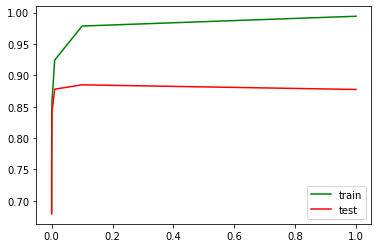

In [27]:
plot_grid_scores(grid_logit, 'logisticregression__C')

For the validation set:

In [28]:
grid_logit.score(text_test, y_test)

0.87812000000000001

**Теперь давайте сделаем то же самое со случайным лесом. Мы видим, что с помощью логистической регрессии мы достигаем лучшей точности с меньшими усилиями.**

In [29]:
from sklearn.ensemble import RandomForestClassifier

In [30]:
forest = RandomForestClassifier(n_estimators=200, 
                                n_jobs=-1, random_state=17)

In [31]:
%%time
forest.fit(X_train, y_train)

CPU times: user 4min 32s, sys: 1.97 s, total: 4min 34s
Wall time: 1min 27s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, random_state=17, verbose=0,
                       warm_start=False)

In [32]:
round(forest.score(X_test, y_test), 3)

0.85499999999999998

### XOR-Проблема
Давайте теперь рассмотрим пример, где линейные модели хуже.

Линейные методы классификации все еще определяют очень простую разделяющую поверхность - гиперплоскость. Самый известный игрушечный пример, где классы не могут быть разделены гиперплоскостью (или линией) без ошибок, - это "проблема XOR".

XOR-это "исключающее ИЛИ", булева функция со следующей таблицей истинности:


<img src='../../img/XOR_table.gif'>

XOR - это название, данное простой задаче бинарной классификации, в которой классы представлены в виде вытянутых по дагонали пересекающихся облаков точек.

In [33]:
# creating dataset
rng = np.random.RandomState(0)
X = rng.randn(200, 2)
y = np.logical_xor(X[:, 0] > 0, X[:, 1] > 0)

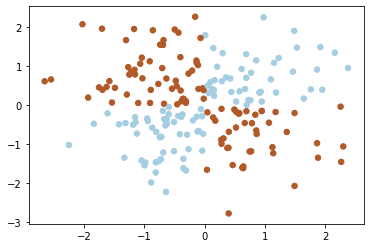

In [34]:
plt.scatter(X[:, 0], X[:, 1], s=30, c=y, cmap=plt.cm.Paired);

Очевидно, что нельзя провести одну прямую линию, чтобы отделить один класс от другого без ошибок. Поэтому логистическая регрессия плохо справляется с этой задачей.

In [35]:
def plot_boundary(clf, X, y, plot_title):
    xx, yy = np.meshgrid(np.linspace(-3, 3, 50),
                     np.linspace(-3, 3, 50))
    clf.fit(X, y)
    # plot the decision function for each datapoint on the grid
    Z = clf.predict_proba(np.vstack((xx.ravel(), yy.ravel())).T)[:, 1]
    Z = Z.reshape(xx.shape)

    image = plt.imshow(Z, interpolation='nearest',
                           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
                           aspect='auto', origin='lower', cmap=plt.cm.PuOr_r)
    contours = plt.contour(xx, yy, Z, levels=[0], linewidths=2,
                               linetypes='--')
    plt.scatter(X[:, 0], X[:, 1], s=30, c=y, cmap=plt.cm.Paired)
    plt.xticks(())
    plt.yticks(())
    plt.xlabel(r'$x_1$')
    plt.ylabel(r'$x_2$')
    plt.axis([-3, 3, -3, 3])
    plt.colorbar(image)
    plt.title(plot_title, fontsize=12);

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: No contour levels were found within the data range.
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: The following kwargs were not used by contour: 'linetypes'
  del sys.path[0]


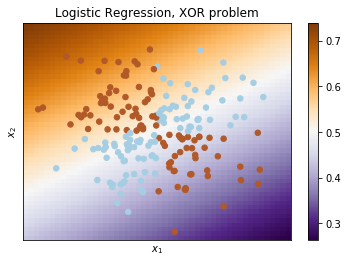

In [36]:
plot_boundary(LogisticRegression(solver='lbfgs'), X, y,
              "Logistic Regression, XOR problem")

А если бы в качестве входных данных были даны полиномиальные признаки (здесь до 2 степени), то проблема была бы решена.

In [37]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

In [38]:
logit_pipe = Pipeline([('poly', PolynomialFeatures(degree=2)), 
                       ('logit', LogisticRegression(solver='lbfgs' ))])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: No contour levels were found within the data range.
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: The following kwargs were not used by contour: 'linetypes'
  del sys.path[0]


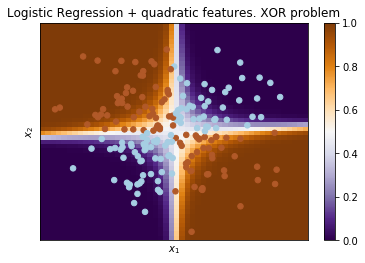

In [39]:
plot_boundary(logit_pipe, X, y,
              "Logistic Regression + quadratic features. XOR problem")

Здесь логистическая регрессия все еще создает гиперплоскость, но в 6-мерном пространстве признаков $1, x_1, x_2, x_1^2, x_1x_2$ и $x_2^2$. Когда мы проецируем на исходное пространство объектов $x_1, x_2$, граница оказывается нелинейной.

На практике полиномиальные функции действительно помогают, но строить их явно вычислительно неэффективно. SVM с ядровым трюком работает гораздо быстрее. При таком подходе вычисляется только расстояние между объектами (определяемое функцией ядра) в многомерном пространстве, и нет необходимости находить комбинаторно большое число признаков.

### Полезные ресурсы
- Основной курс [сайт](https://mlcourse.ai), [репозиторий курса](https://github.com/Yorko/mlcourse.ai), и YouTube [канал](https://www.youtube.com/watch?v=QKTuw4PNOsU&list=PLVlY_7IJCMJeRfZ68eVfEcu-UcN9BbwiX)
- Medium ["story"](https://medium.com/open-machine-learning-course/open-machine-learning-course-topic-4-linear-classification-and-regression-44a41b9b5220) based on this notebook
- Материалы курса [Kaggle Dataset](https://www.kaggle.com/kashnitsky/mlcourse)
- [Статья](https://habrahabr.ru/company/ods/blog/323890/) на русском на Habrahabr с темже материалом. И [лекция](https://youtu.be/oTXGQ-_oqvI) на YouTube
- Хороший и краткий обзор линейных моделей дан в книге [“Deep Learning”](http://www.deeplearningbook.org) (I. Goodfellow, Y. Bengio, and A. Courville).
- Линейные модели рассматриваются практически в каждой книге ML. Мы рекомендуем “Pattern Recognition and Machine Learning” (C. Bishop) и “Machine Learning: A Probabilistic Perspective” (K. Murphy).
- Если вы предпочитаете тщательный обзор линейной модели с точки зрения статистики, то посмотрите “The elements of statistical learning” (T. Hastie, R. Tibshirani, and J. Friedman).
- Книга “Machine Learning in Action” (P. Harrington) познакомит вас с реализацией классических алгоритмов ML на чистом Python.
- [Scikit-learn](http://scikit-learn.org/stable/documentation.html) библиотека. Эти ребята упорно работают над написанием действительно понятной документацией.
- Scipy 2017 [scikit-learn tutorial](https://github.com/amueller/scipy-2017-sklearn) by Alex Gramfort и Andreas Mueller.
- Еще один [курс ML](https://github.com/diefimov/MTH594_MachineLearning) с очень хорошим материалом.
- [Реализации](https://github.com/rushter/MLAlgorithms) многоих ML алгоритмов. Ищите linear regression и logistic regression.

Author: [Yury Kashnitskiy](https://yorko.github.io). Translated and edited by [Christina Butsko](https://www.linkedin.com/in/christinabutsko/), [Nerses Bagiyan](https://www.linkedin.com/in/nersesbagiyan/), [Yulia Klimushina](https://www.linkedin.com/in/yuliya-klimushina-7168a9139), and [Yuanyuan Pao](https://www.linkedin.com/in/yuanyuanpao/). This material is subject to the terms and conditions of the [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/) license. Free use is permitted for any non-commercial purpose.